In [1]:
# Import des librairies nécessaires
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly

# Chargement et nettoyage du dataset

Le dataset étant lourd, il est chargé en chunk pour faciliter l'utilisation de la mémoire.
On ne garde que les colonnes avec un taux de valeurs manquantes inférieur à 70%

In [2]:
# nombre de lignes à charger en même temps en mémoire
chunksize = 10 ** 4
filename = 'en.openfoodfacts.org.products.csv'
nan_rates = []
for chunk in pd.read_csv(filename, chunksize=chunksize, sep='\t', low_memory=False):
    nan_rates.append(chunk.isna().mean(axis=0))
# moyenne des taux de remplissage des chunks
inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)
cols_to_load = inds_nan_rate[inds_nan_rate < 0.7].index.tolist()
df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)

C:\Users\BENAVEN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
len1=len(df)
len1

1729208

Le nutriscore est basé sur les valeurs nutritionnelles.
Calcul du taux de valeurs manquantes parmi les valeurs nutritionnelles par individu

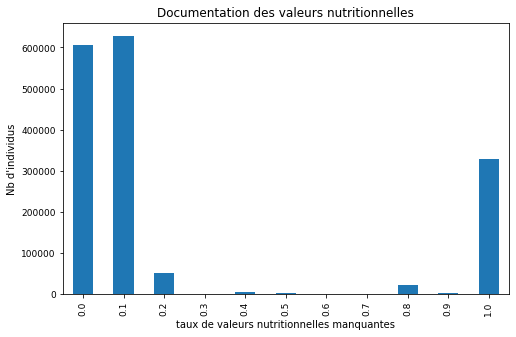

In [4]:
#calcul du taux de NaN par lignes pour les 10 valeurs nutritionelles
dict_nan={}
for i in np.linspace(0,1,11):
    nan_i=(df[df.columns[df.columns.str.contains('_100g')]].isna().mean(axis=1)==i).sum()
    dict_nan[round(i,1)]=nan_i
pd.DataFrame.from_dict(dict_nan, orient='index').plot.bar(title="Documentation des valeurs nutritionnelles",figsize=(8,5), legend = False, xlabel = 'taux de valeurs nutritionnelles manquantes', ylabel= "Nb d'individus", fontsize = 9);

In [5]:
#les individus ayant des taux de NaN faibles sont regroupés vers 0, 0.1, 0.2. Les autres individus sont supprimés
df=df[df[df.columns[df.columns.str.contains('_100g')]].isna().mean(axis=1)<=0.2]

In [6]:
len2=len(df)
len1-len2

442715

Identification et suppression des doublons

In [7]:
# Nombre de doublons
df.duplicated('code',keep=False).sum()

330

In [8]:
# identification des doublons et de la ligne la mieux documentéé pour chaque ID puis suppression des doublons
df_duplicates=df[df.duplicated('code',keep=False)].sort_values('code')
idx_to_keep=[]
for code in df_duplicates['code'].unique():
    idxmin=df_duplicates[df_duplicates['code']==code].isna().mean(axis=1).idxmin()
    idx_to_keep.append(idxmin)
idx_to_drop=[idx for idx in df_duplicates.index.tolist() if idx not in idx_to_keep]
df_clean=df.drop(labels=idx_to_drop)

In [9]:
df_clean.duplicated('code',keep=False).sum()

0

Suppression des colonnes inutiles pour l'analyse

In [10]:
col_to_remove=df.columns[df.columns.str.contains('url|_tags|_en')]
col_to_remove_bis=['created_t','created_datetime','last_modified_t','last_modified_datetime','creator','code','categories','ingredients_text',
                   'ingredients_that_may_be_from_palm_oil_n','main_category','nutrition-score-fr_100g','states','additives_n','ingredients_from_palm_oil_n']

In [11]:
df_clean=df_clean.drop(col_to_remove_bis,axis=1)
df_clean=df_clean.drop(col_to_remove,axis=1)

In [12]:
df_clean.columns

Index(['product_name', 'brands', 'countries', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g'],
      dtype='object')

Etude des valeurs nutritionnelles

In [13]:
df_nutri=df_clean[df_clean.columns[df_clean.columns.str.contains('_100g')]]

In [14]:
#suppression des valeurs nutritionnelles négatives
idx_to_drop=[]
for col in df_nutri.columns:
    idx_neg=df_nutri[df_nutri[col]<0].index.tolist()
    idx_to_drop.append(idx_neg)
idx_to_drop=[i for sublist in idx_to_drop for i in sublist]
idx_to_drop=set(idx_to_drop)
df_nutri=df_nutri.drop(labels=idx_to_drop)

In [15]:
#suppression des lignes ayant une énergie sup à 2000 kcal
df_nutri=df_nutri.drop(labels=df_nutri[df_nutri['energy-kcal_100g']>2000].index.tolist())

In [16]:
#suppression des lignes dont la somme des nutriments est supérieur à 100
df_nutri=df_nutri.drop(labels=df_nutri[df_nutri[['fat_100g','carbohydrates_100g','proteins_100g','salt_100g']].sum(axis=1)>100].index.tolist())

In [17]:
#suppression des lignes ne respectant pas les sous-catégories (ex:acides gras saturés supérieurs à total lipides)
idx_to_drop=[]
idx_to_drop.append(df_nutri[df_nutri['saturated-fat_100g']>df_nutri['fat_100g']].index.tolist())
idx_to_drop.append(df_nutri[df_nutri['sugars_100g']>df_nutri['carbohydrates_100g']].index.tolist())
idx_to_drop.append(df_nutri[df_nutri['sodium_100g']>df_nutri['salt_100g']].index.tolist())
idx_to_drop=[i for sublist in idx_to_drop for i in sublist]
df_nutri=df_nutri.drop(labels=idx_to_drop)

In [18]:
#suppression des incohérences (Lipides, glucides ou protéines non nuls mais énergie nulle)
idx_to_drop=df_nutri[(df_nutri['energy-kcal_100g']==0)&((df_nutri['fat_100g']!=0)|(df_nutri['carbohydrates_100g']!=0)|(df_nutri['proteins_100g']!=0))].index.tolist()
df_nutri=df_nutri.drop(labels=idx_to_drop)

In [19]:
# Matrice de corrélation
mat_corr=df_nutri.corr('pearson')
mat_corr

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
energy-kcal_100g,1.000000,0.994862,0.735622,0.537864,0.410621,0.271407,0.203297,-0.035673,-0.035673
energy_100g,0.994862,1.000000,0.473378,0.344524,0.267011,0.175286,0.130851,-0.022439,-0.022439
fat_100g,0.735622,0.473378,1.000000,0.700889,-0.117044,-0.059351,0.149170,-0.009896,-0.009897
saturated-fat_100g,0.537864,0.344524,0.700889,1.000000,-0.062728,0.062608,0.146454,-0.012359,-0.012359
carbohydrates_100g,0.410621,0.267011,-0.117044,-0.062728,1.000000,0.677055,-0.200065,-0.085624,-0.085624
sugars_100g,0.271407,0.175286,-0.059351,0.062608,0.677055,1.000000,-0.271084,-0.105791,-0.105794
proteins_100g,0.203297,0.130851,0.149170,0.146454,-0.200065,-0.271084,1.000000,0.076922,0.076923
salt_100g,-0.035673,-0.022439,-0.009896,-0.012359,-0.085624,-0.105791,0.076922,1.000000,1.000000
sodium_100g,-0.035673,-0.022439,-0.009897,-0.012359,-0.085624,-0.105794,0.076923,1.000000,1.000000


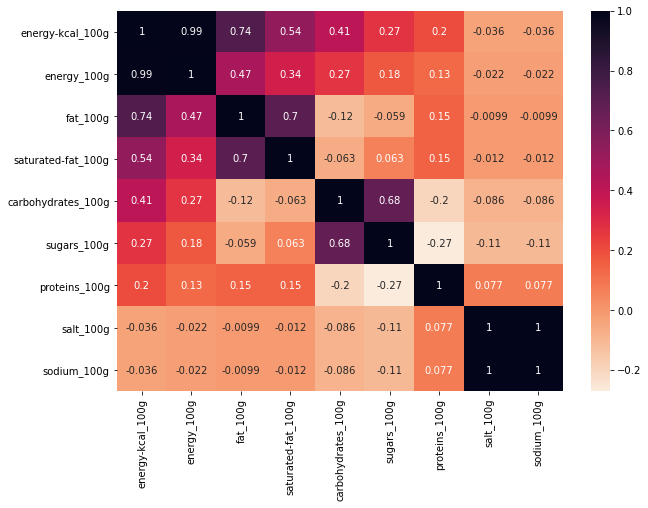

In [20]:
plt.figure(figsize=(10,7))
sns.heatmap(mat_corr, annot=True, cmap = 'rocket_r');

In [21]:
#Après ce nettoyage sur les valeurs nutritionnelles, on garde ces index dans le dataset df_clean
df_clean=df_clean.loc[df_nutri.index]

In [22]:
#Suppression des colonnes 'sodium_100g' et 'energy_100g' car très bien corrélées avec 'salt_100g' et 'energy-kcal_100g'
df_clean=df_clean.drop(columns=['sodium_100g','energy_100g'],axis=1)

In [23]:
len3=len(df_clean)
len2-len3

22216

In [24]:
df_clean.columns

Index(['product_name', 'brands', 'countries', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g'],
      dtype='object')

# Imputation des valeurs nutritionnelles
On teste 3 méthodes pour garder la plus efficace : Imputation par 0, par la médiane et imputation itérative

In [25]:
df_nan=df_clean[df_clean[['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g']].isna().sum(axis=1)>0]
df_nan=df_nan[['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g']]
df_filled=df_clean.drop(df_nan.index)[['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g']]

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

In [27]:
# Définition des méthodes d'imputation
zero_imputer=SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
median_imputer=SimpleImputer(missing_values=np.nan,strategy='median')
iter_imputer = IterativeImputer(random_state=0,min_value=0, max_value=[2000,100,100,100,100,100,100])

In [28]:
# Méthode 1) : Imputation par 0
zero_imputer.fit(df_clean[['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g']])
df_clean_zero=zero_imputer.transform(df_clean[['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g']])
df_clean_zero=pd.DataFrame(df_clean_zero,index=df_clean.index,columns=['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g'])

In [29]:
# Méthode 2) : Imputation par la médiane
median_imputer.fit(df_clean[['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g']])
df_clean_median=median_imputer.transform(df_clean[['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g']])
df_clean_median=pd.DataFrame(df_clean_median,index=df_clean.index,columns=['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g'])

In [30]:
# Méthode 3) : Imputation itérative
iter_imputer.fit(df_clean[['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g']])
df_clean_iter=iter_imputer.transform(df_clean[['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g']])
df_clean_iter=pd.DataFrame(df_clean_iter,index=df_clean.index,columns=['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g'])

In [31]:
# Test des méthodes sur les valeurs nutri
# Ajout de valeurs manquantes aléatoirement dans le dataset des valeurs connues (df_filled)
mat_nan=np.random.random(df_filled.shape)<0.2
df_filled_nan=df_filled.mask(mat_nan)

In [32]:
# Imputation via les 3 méthodes des valeurs supprimées aléatoirement
df_filled_test_zero=zero_imputer.transform(df_filled_nan)
df_filled_test_median=median_imputer.transform(df_filled_nan)
df_filled_test_iter=iter_imputer.transform(df_filled_nan)

In [33]:
# Calcul de l'erreur de chaque méthode en comparant les valeurs imputées aux valeurs réelles
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df_filled,df_filled_test_zero))
print(mean_squared_error(df_filled,df_filled_test_median))
print(mean_squared_error(df_filled,df_filled_test_iter))

3406.489769633892
1132.9692724133504
327.53613175670336


In [34]:
# On garde la méthode iterative. Remplacement des valeurs imputées dans le dataset principal (df_clean)
df_clean.loc[:,['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g']]=df_clean_iter

In [35]:
# Description des valeurs quantitatives
df_clean.describe()

,nutriscore_score,nova_group,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g
count,637388.000000,531365.000000,1.264277e+06,1.264277e+06,1.264277e+06,1.264277e+06,1.264277e+06,1.264277e+06,1.264277e+06
mean,9.137301,3.460188,2.775897e+02,1.379777e+01,5.089854e+00,2.789006e+01,1.313520e+01,8.712533e+00,1.217453e+00
std,8.869863,0.936248,1.946531e+02,1.743084e+01,7.615170e+00,2.779659e+01,1.933436e+01,9.691143e+00,3.785314e+00
min,-15.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000,3.000000,1.090000e+02,9.100000e-01,1.000000e-01,3.500000e+00,6.000000e-01,1.540000e+00,8.250000e-02
50%,10.000000,4.000000,2.650000e+02,7.400000e+00,1.900000e+00,1.500000e+01,3.570000e+00,6.000000e+00,5.825000e-01
75%,16.000000,4.000000,4.000000e+02,2.143000e+01,7.140000e+00,5.283000e+01,1.800000e+01,1.250000e+01,1.400000e+00
max,40.000000,4.000000,2.000000e+03,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02


Suppression des variables inutiles pour optimiser la mémoire

In [36]:
del df

In [37]:
del zero_imputer,median_imputer,iter_imputer,df_clean_zero,df_clean_median,df_clean_iter,df_filled, df_filled_test_zero,df_filled_test_median,df_filled_test_iter,df_filled_nan,mat_nan

In [38]:
df_clean.shape

(1264277, 15)

Nettoyage des valeurs 'string' pour homogénéisation

In [39]:
# Mise en majuscule des nutriscores
df_clean['nutriscore_grade']=df_clean['nutriscore_grade'].str.upper()

In [40]:
# Nettoyage des catégories de produits (suppression de -)
df_clean['pnns_groups_1'].replace('sugary-snacks', "Sugary snacks", inplace = True)
df_clean['pnns_groups_1'].replace('fruits-and-vegetables', "Fruits and vegetables", inplace = True)
df_clean['pnns_groups_1'].replace('cereals-and-potatoes', "Cereals and potatoes", inplace = True)
df_clean['pnns_groups_1'].replace('salty-snacks', "Salty snacks", inplace = True)
df_clean['pnns_groups_2'].replace('nuts', "Nuts", inplace = True)
df_clean['pnns_groups_2'].replace('legumes', "Legumes", inplace = True)
df_clean['pnns_groups_2'].replace('cereals', "Cereals", inplace = True)
df_clean['pnns_groups_2'].replace('fruits', "Fruits", inplace = True)
df_clean['pnns_groups_2'].replace('vegetables', "Vegetables", inplace = True)

In [41]:
#Nettoyage des noms de pays
df_clean['countries'].replace(['en:fr','en:france','en:FR','en:France','Francia','Frankreich'],"France", inplace = True)
df_clean['countries'].replace(['en:us','en:United States'],"United States", inplace = True)
df_clean['countries'].replace(['en:es','España','en:spain','en:spain'],"Spain", inplace = True)
df_clean['countries'].replace(['en:it','Italia','en:Italy'],"Italy", inplace = True)
df_clean['countries'].replace(['en:be','en:BE','Belgique','en:belgium'],"Belgium", inplace = True)
df_clean['countries'].replace(['en:ch','en:CH','Suisse'],"Switzerland", inplace = True)
df_clean['countries'].replace(['Deutschland','en:Germany','en:de'],"Germany", inplace = True)
df_clean['countries'].replace(['en:ca'],"Canada", inplace = True)
df_clean['countries'].replace(['en:gb', 'en:United Kingdom'],"United Kingdom", inplace = True)
df_clean['countries'].replace(['México'],"Mexico", inplace = True)
df_clean['countries'].replace(['en:au'],"Australia", inplace = True)
df_clean['countries'].replace(['Polska'],"Poland", inplace = True)
df_clean['countries'].replace(['en:ie'],"Ireland", inplace = True)

Sauvegarde du dataset dans un fichier .csv pour le récupérer plus facilement

In [42]:
df_clean.to_csv(r'C:\Users\BENAVEN\Desktop\Stevan\Formation OCR\Projet 3 - Concevez une application au service de la santé publique\df_clean.csv')

In [43]:
df_clean['pnns_groups_2'].unique()

array(['unknown', 'Dressings and sauces', 'One-dish meals',
       'Biscuits and cakes', 'Fruits', 'Cheese', 'Meat', 'Bread',
       'Fish and seafood', 'Salty and fatty products', 'Fruit juices',
       'Sweets', 'Fats', 'Vegetables', 'Dairy desserts', 'pastries',
       'Dried fruits', 'Pizza pies and quiche', 'Sweetened beverages',
       'Unsweetened beverages', 'Nuts', 'Cereals', 'Appetizers',
       'Breakfast cereals', 'Chocolate products', 'Milk and yogurt',
       'Eggs', 'Plant-based milk substitutes', 'Processed meat',
       'Sandwiches', 'Legumes', 'Teas and herbal teas and coffees',
       'Soups', 'Potatoes', 'Artificially sweetened beverages',
       'Ice cream', 'Alcoholic beverages', 'Offals',
       'Waters and flavored waters', 'Fruit nectars',
       'Pizza pies and quiches'], dtype=object)